### Setup

In [20]:
import pandas as pd
import os
import numpy as np

# Loading data

In [21]:
path = os.path.abspath('')
path = path + "/engineered_data_250ms_window80_step8.csv"
df = pd.read_csv(path)

diction = {'Dany':0, 'Felix':1, 'Julian':2, 'Mark':3,'Martin':4,'Michele':5,'Paul':6}

for index,row in df['Participant'].items():
    df.loc[index,'Participant'] = diction[row]

List = ["Window", "Participant", "Run", "Path"]
for name in df.columns:
    if "Acceleration" in name and not "Linear" in name:
        List.append(name)

df.drop(df.columns.difference(List),axis=1,inplace=True)
print(df.columns)

df['Path'] = df['Path'].replace({'straight': 0, 'circle': 1})
unique_values = df['Path'].unique()
print("Unique values in the 'path' column:", unique_values)
sample_values = df['Path'].sample(n=10, random_state=1)  # random_state ensures reproducibility
print("Sample of the 'path' column:\n", sample_values)

Index(['Window', 'Participant', 'Path', 'Run',
       'median_Acceleration x (m/s^2)_head_mean',
       'median_Acceleration x (m/s^2)_head_std',
       'median_Acceleration x (m/s^2)_head_last',
       'median_Acceleration x (m/s^2)_head_get_freq',
       'median_Acceleration x (m/s^2)_head_get_weighted_freq',
       'median_Acceleration x (m/s^2)_head_get_power_spectral_entropy',
       'median_Acceleration y (m/s^2)_head_mean',
       'median_Acceleration y (m/s^2)_head_std',
       'median_Acceleration y (m/s^2)_head_last',
       'median_Acceleration y (m/s^2)_head_get_freq',
       'median_Acceleration y (m/s^2)_head_get_weighted_freq',
       'median_Acceleration y (m/s^2)_head_get_power_spectral_entropy',
       'median_Acceleration z (m/s^2)_head_mean',
       'median_Acceleration z (m/s^2)_head_std',
       'median_Acceleration z (m/s^2)_head_last',
       'median_Acceleration z (m/s^2)_head_get_freq',
       'median_Acceleration z (m/s^2)_head_get_weighted_freq',
       'med

In [22]:
df

,Window,Participant,Path,Run,median_Acceleration x (m/s^2)_head_mean,median_Acceleration x (m/s^2)_head_std,median_Acceleration x (m/s^2)_head_last,median_Acceleration x (m/s^2)_head_get_freq,median_Acceleration x (m/s^2)_head_get_weighted_freq,median_Acceleration x (m/s^2)_head_get_power_spectral_entropy,...,median_Acceleration y (m/s^2)_head_last,median_Acceleration y (m/s^2)_head_get_freq,median_Acceleration y (m/s^2)_head_get_weighted_freq,median_Acceleration y (m/s^2)_head_get_power_spectral_entropy,median_Acceleration z (m/s^2)_head_mean,median_Acceleration z (m/s^2)_head_std,median_Acceleration z (m/s^2)_head_last,median_Acceleration z (m/s^2)_head_get_freq,median_Acceleration z (m/s^2)_head_get_weighted_freq,median_Acceleration z (m/s^2)_head_get_power_spectral_entropy
0,1,0,1,1,-1.441885,1.664816,0.079860,0.0000,0.145976,2.644804,...,4.797909,0.0,0.129416,2.071018,9.072312,0.704681,8.513065,0.0,0.050999,0.042980
1,2,0,1,1,-1.354020,1.668913,-1.607379,0.0000,0.152539,2.750950,...,2.652444,0.0,0.122570,1.492870,9.008865,0.690520,9.079565,0.0,0.050340,0.041829
2,3,0,1,1,-1.276945,1.523551,-1.642075,0.0000,0.149108,2.703146,...,3.206981,0.0,0.121614,1.480909,9.042798,0.696329,9.366405,0.0,0.051699,0.042340
3,4,0,1,1,-1.242948,1.392956,-2.495415,0.0000,0.150805,2.605224,...,1.944168,0.0,0.117329,1.327042,9.033597,0.636086,9.246166,0.0,0.046729,0.036069
4,5,0,1,1,-1.288124,1.336146,-1.344168,0.0000,0.152741,2.364361,...,2.832504,0.0,0.120923,1.344156,9.084389,0.627959,9.212367,0.0,0.044890,0.035065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,28,6,0,3,-1.435649,1.551049,0.448056,0.0000,0.167106,2.127912,...,2.489134,0.0,0.128121,1.610478,8.822307,1.467203,10.273584,0.0,0.106711,0.158179
1302,29,6,0,3,-1.293418,1.718175,2.827120,0.0000,0.165010,2.700931,...,5.612365,0.0,0.143186,1.864197,8.896455,1.409996,7.843374,0.0,0.099032,0.146541
1303,30,6,0,3,-1.085459,1.779832,1.439881,0.0000,0.161288,3.135314,...,5.775377,0.0,0.133831,1.527957,8.752814,1.292409,7.817053,0.0,0.097040,0.132847
1304,31,6,0,3,-0.873713,1.808765,0.369691,0.0000,0.164181,3.253732,...,5.837291,0.0,0.132983,1.356970,8.692852,1.211373,7.888538,0.0,0.092626,0.120462


## Removing nan values

In [23]:
#create train/test set
#should maybe do random runs in the future
X_Train = df[df['Run'] < 4].copy()
X_Test = df[df['Run'] == 4].copy()

# Extracting targets
Y_Train = X_Train.pop('Participant')
Y_Test = X_Test.pop('Participant')

# Verifying the final shapes and content of datasets
print("X_Train shape:", X_Train.shape)
print("X_Test shape:", X_Test.shape)
print("Y_Train shape:", Y_Train.shape)
print("Y_Test shape:", Y_Test.shape)

#Display a few rows to confirm correct data setup
print(X_Train['Path'].sample(3))
print(X_Test['Path'].sample(3))

# In order to solve the NaN issue, i try to locate the values
print("NaN in X_Train:", X_Train.isnull().sum().sum())
print("NaN in Y_Train:", Y_Train.isnull().sum().sum())
print("NaN in X_Test:", X_Test.isnull().sum().sum())

# Find rows with NaN values in X_Train
nan_rows_X_Train = X_Train[X_Train.isnull().any(axis=1)]
print("Rows with NaN values in X_Train:")
print(nan_rows_X_Train)

# Find rows with NaN values in X_Test
nan_rows_X_Test = X_Test[X_Test.isnull().any(axis=1)]
print("Rows with NaN values in X_Test:")
print(nan_rows_X_Test)

# Print the number of unique rows that have NaN in X_Train and X_Test
print("Number of unique rows with NaN in X_Train:", nan_rows_X_Train.shape[0])
print("Number of unique rows with NaN in X_Test:", nan_rows_X_Test.shape[0])

# In order to solve the NaN issue in the SVM I will drop the the NaN values
# Remove rows with NaN values from X_Train and X_Test
X_Train_cleaned = X_Train.dropna()
X_Test_cleaned = X_Test.dropna()

# Ensure the target variables are aligned
Y_Train_cleaned = Y_Train[X_Train_cleaned.index]
Y_Test_cleaned = Y_Test[X_Test_cleaned.index]

# Ensure Y_Train_cleaned and Y_Test_cleaned is of integer type
Y_Train_cleaned = Y_Train_cleaned.astype(int)
Y_Test_cleaned = Y_Test_cleaned.astype(int)

X_Train shape: (1019, 21)
X_Test shape: (287, 21)
Y_Train shape: (1019,)
Y_Test shape: (287,)
1288    0
1120    1
803     1
Name: Path, dtype: int64
929     0
762     0
1093    0
Name: Path, dtype: int64
NaN in X_Train: 1380
NaN in Y_Train: 0
NaN in X_Test: 255
Rows with NaN values in X_Train:
      Window  Path  Run  median_Acceleration x (m/s^2)_head_mean  \
15        16     1    1                                -2.147170   
16        17     1    1                                -2.186962   
17        18     1    1                                -2.298860   
18        19     1    1                                -2.391976   
19        20     1    1                                -2.442028   
...      ...   ...  ...                                      ...   
1179      45     1    3                                      NaN   
1180      46     1    3                                      NaN   
1205       1     0    1                                 0.636521   
1239       1     0    2  

In [24]:
# Check for NaN values in Y_Train
print("NaN in Y_Train:", Y_Train_cleaned.isnull().sum().sum())
print("NaN in Y_Train:", Y_Test_cleaned.isnull().sum().sum())

# Check the unique values in Y_Train
print("Unique values in Y_Train:", Y_Train_cleaned.unique())
print("Unique values in Y_Train:", Y_Test_cleaned.unique())



NaN in Y_Train: 0
NaN in Y_Train: 0
Unique values in Y_Train: [0 1 2 3 4 5 6]
Unique values in Y_Train: [0 1 2 3 4 5 6]


# Training SVM

In [25]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_Train_scaled = scaler.fit_transform(X_Train_cleaned)

# Transform the test data
X_Test_scaled = scaler.transform(X_Test_cleaned)

# Using the scaled data for training and prediction
# Define and train the RBF kernel SVM model
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1)
rbf.fit(X_Train_scaled, Y_Train_cleaned)

# Define and train the polynomial kernel SVM model with degree 20
poly = svm.SVC(kernel='poly', degree=20, C=1)
poly.fit(X_Train_scaled, Y_Train_cleaned)

# Define and train the linear kernel SVM model
clf = svm.SVC(kernel='linear', C=1)
clf.fit(X_Train_scaled, Y_Train_cleaned)

# Make predictions on the test set using all three models
y_pred_rbf = rbf.predict(X_Test_scaled)
y_pred_poly = poly.predict(X_Test_scaled)
y_pred_linear = clf.predict(X_Test_scaled)

print("RBF Kernel SVM Predictions:", y_pred_rbf)
print("Polynomial Kernel SVM Predictions:", y_pred_poly)
print("Linear Kernel SVM Predictions:", y_pred_linear)

RBF Kernel SVM Predictions: [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6]
Polynomial Kernel SVM Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 3 3 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 2 2 2 2 2 2 0 0 2 0 0 2
 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [26]:
# Print the predictions and accuracy from all three models
print("Accuracy (RBF):", metrics.accuracy_score(Y_Test_cleaned, y_pred_rbf))

print("Accuracy (Polynomial):", metrics.accuracy_score(Y_Test_cleaned, y_pred_poly))

print("Accuracy (Linear):", metrics.accuracy_score(Y_Test_cleaned, y_pred_linear))

Accuracy (RBF): 0.08812260536398467
Accuracy (Polynomial): 0.41762452107279696
Accuracy (Linear): 0.9003831417624522


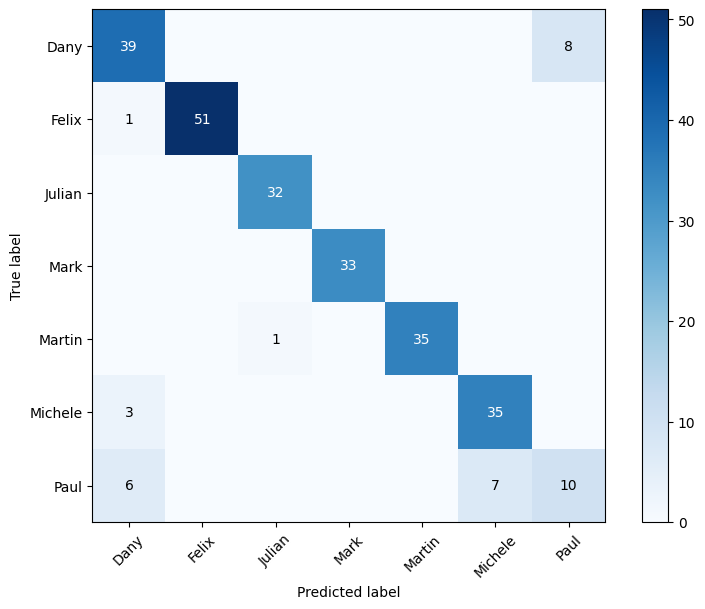

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(Y_Test_cleaned, y_pred_linear)


plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(diction))
plt.xticks(tick_marks, diction, rotation=45)
plt.yticks(tick_marks, diction)

# Labeling the cells with their respective counts if greater than zero
thresh = cm.max() / 2.  # for text color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] > 0:
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()




# Training Xgboost

Accuracy: 0.9163763066202091


<Axes: >

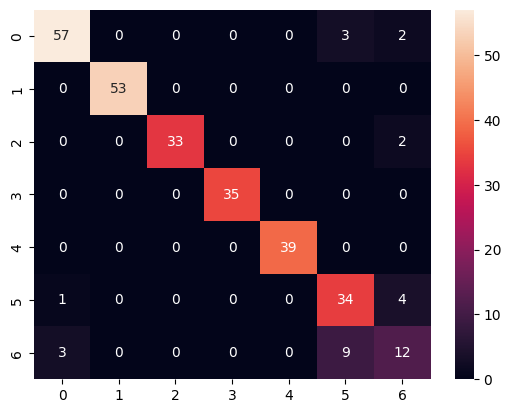

In [52]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
model = XGBClassifier(tree_method = 'hist', max_depth = 4, objective='multi:softprob')
model.fit(X_Train,Y_Train)
y_pred = model.predict(X_Test)
Y_Test = Y_Test.astype('int')
print("Accuracy:",metrics.accuracy_score(Y_Test , y_pred))

cm = confusion_matrix(Y_Test,y_pred)
sns.heatmap(cm,annot=True)

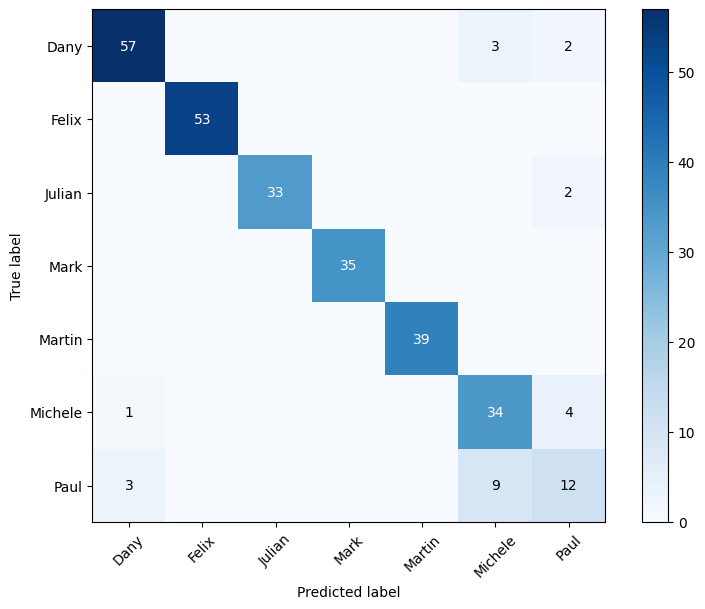

In [44]:
# plot the confusion matrix as we did for the SVM

plt.figure(figsize=(8, 6))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.colorbar()

tick_marks = np.arange(len(diction))
plt.xticks(tick_marks, diction, rotation=45)
plt.yticks(tick_marks, diction)

# Labeling the cells with their respective counts if greater than zero
thresh = cm.max() / 2.  # for text color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] > 0:
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Parameter tuning

In [ ]:
#plot the accuracy with different max_depth

from tqdm import tqdm

accuracy = []

for i in tqdm(range(1, 11)):
    model = XGBClassifier(max_depth=i, tree_method = 'hist',objective='multi:softprob')
    # use cross validation to evaluate the model
    accuracies = cross_validation(df_copy, 42, model, 3)

    accuracy.append((np.mean(accuracies), np.std(accuracies)))

    




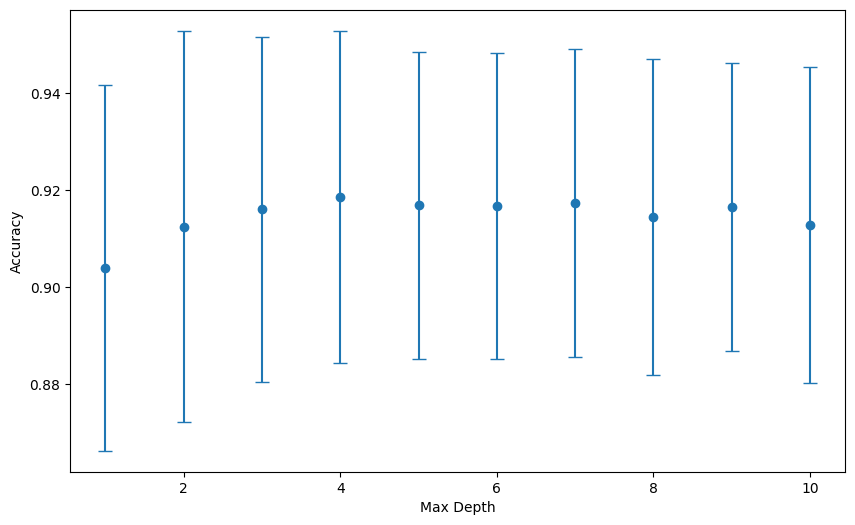

In [49]:

plt.figure(figsize=(10, 6))

plt.errorbar(range(1, 11), [i[0] for i in accuracy], yerr=[i[1] for i in accuracy], fmt='o', capsize=5)

plt.xlabel('Max Depth')

plt.ylabel('Accuracy')


plt.show()

# Feature importance

Elapsed time to compute the importances: 2.487 seconds


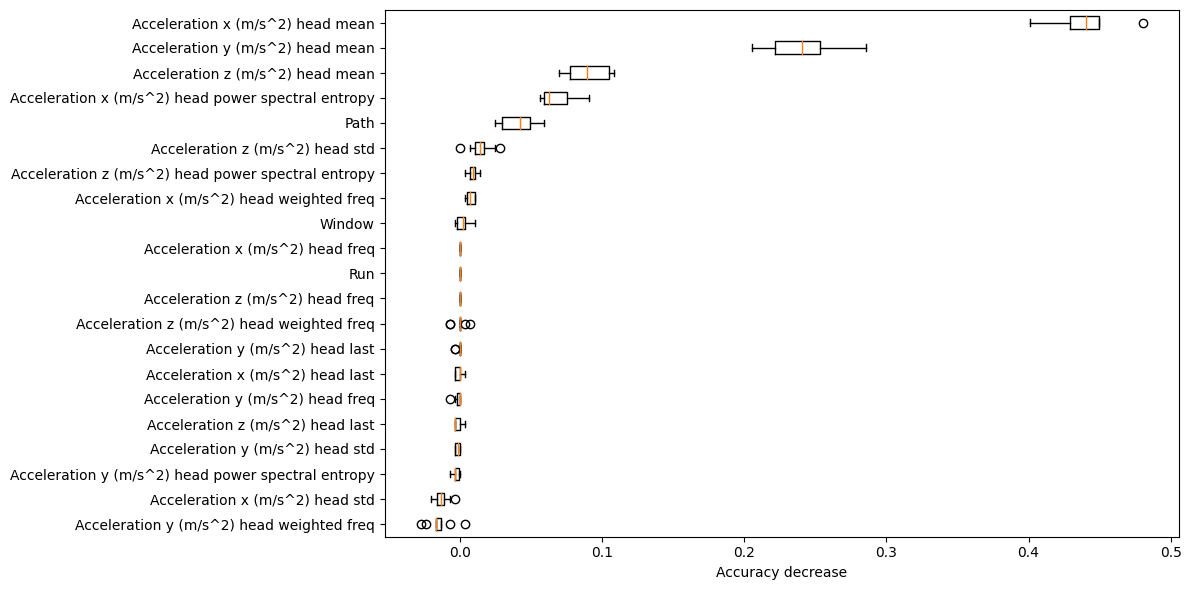

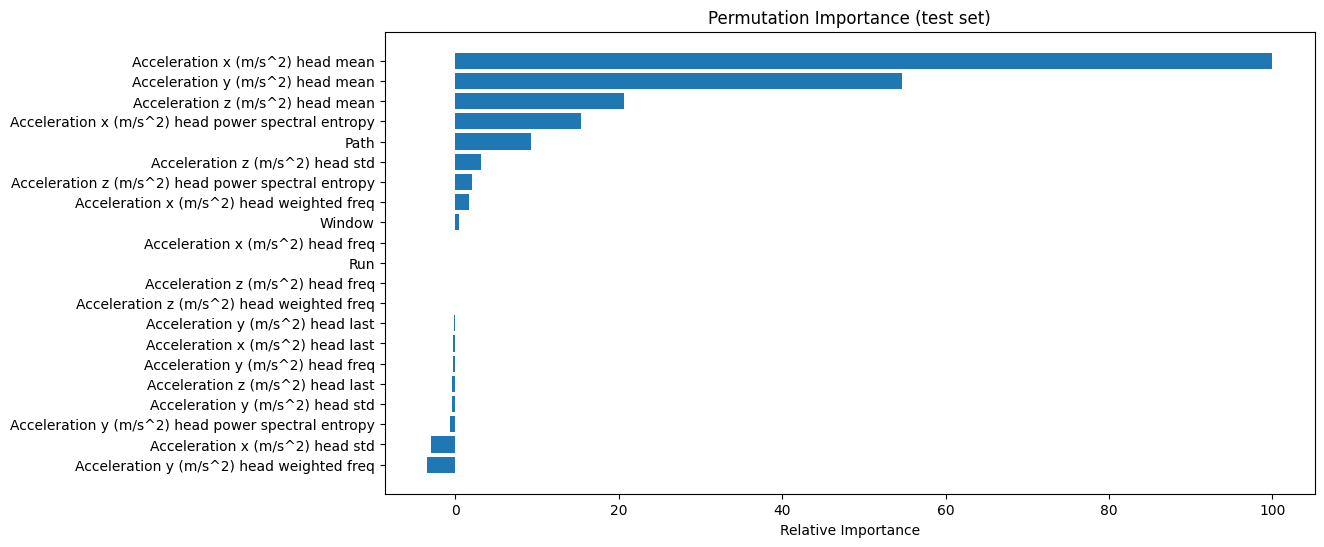

In [56]:
import time
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

start_time = time.time()

result = permutation_importance(model, X_Test, Y_Test, n_repeats=10, random_state=42, n_jobs=2)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "

        f"{elapsed_time:.3f} seconds")

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(12, 6))

columns = X_Test.columns

columns = columns.str.replace('median_','').str.replace('get_','').str.replace('_',' ')

plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=columns[sorted_idx])
plt.xlabel('Accuracy decrease')

#plt.title("Permutation Importance (test set)")

plt.tight_layout()

plt.show()

# plot the permutation importance with correct naming

feature_importance = result.importances_mean

feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5


plt.figure(figsize=(12, 6))

plt.barh(pos, feature_importance[sorted_idx], align='center')

plt.yticks(pos, columns[sorted_idx])

plt.xlabel('Relative Importance')

plt.title('Permutation Importance (test set)')

plt.show()



In [51]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Cross-Validaion

In [29]:
# print the number of unique runs per individual
df.groupby(['Participant','Path'])['Run'].nunique()

Participant  Path
0            0       4
             1       4
1            0       4
             1       4
2            0       4
             1       4
3            0       4
             1       4
4            0       4
             1       4
5            0       4
             1       4
6            0       3
             1       4
Name: Run, dtype: int64

In [30]:
df['Run'].unique()

array([1, 2, 3, 4])

In [31]:
from itertools import combinations

# a function to implement cross validation given the number of runs we want to use for training (we have 4 in total)
def cross_validation(df, seed, model, training_runs = 3):
    runs = df['Run'].unique() # typically [1,2,3,4] in our case


    if training_runs >= len(runs):
        raise ValueError("The number of training runs should be less than the total number of runs")

    # all possible combinations of runs given the number of runs we want to use for training


    training_combinations = list(combinations(runs, training_runs))

    print(f"Number of training combinations: {len(training_combinations)}")

    print(f"The combinations: {training_combinations}")

    # we will store the accuracy for each combination of runs


    accuracies = []

    for training_set in training_combinations:


        X_Train = df[df['Run'].isin(training_set)].copy()

        X_Test = df[~df['Run'].isin(training_set)].copy()

        Y_Train = X_Train['Participant'].copy()

        Y_Test = X_Test['Participant'].copy()

        X_Test.drop(['Participant'],axis=1,inplace=True)

        X_Train.drop(['Participant'],axis=1,inplace=True)

        model.fit(X_Train,Y_Train)

        y_pred = model.predict(X_Test)

        Y_Test = Y_Test.astype('int')

        accuracies.append(metrics.accuracy_score(Y_Test , y_pred))

    return accuracies









In [32]:

# convert the path column to an int representation

df_copy = df.copy(deep=True)

df_copy.loc[df_copy['Path'] == 'circle', "Path"] = 1

df_copy.loc[df_copy['Path'] == 'straight',"Path"] = 0

df_copy['Path'] = df_copy['Path'].astype(int)






In [33]:
model = XGBClassifier(tree_method = 'hist',objective='multi:softprob')


accuracies = cross_validation(df_copy, 42, model, 2)

Number of training combinations: 6
The combinations: [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


In [ ]:
accuracies

Number of training combinations: 4
The combinations: [(1,), (2,), (3,), (4,)]
Number of training combinations: 4
The combinations: [(1,), (2,), (3,), (4,)]
Number of training combinations: 6
The combinations: [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
Number of training combinations: 6
The combinations: [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
Number of training combinations: 4
The combinations: [(1, 2, 3), (1, 2, 4), (1, 3, 4), (2, 3, 4)]
Number of training combinations: 4
The combinations: [(1, 2, 3), (1, 2, 4), (1, 3, 4), (2, 3, 4)]


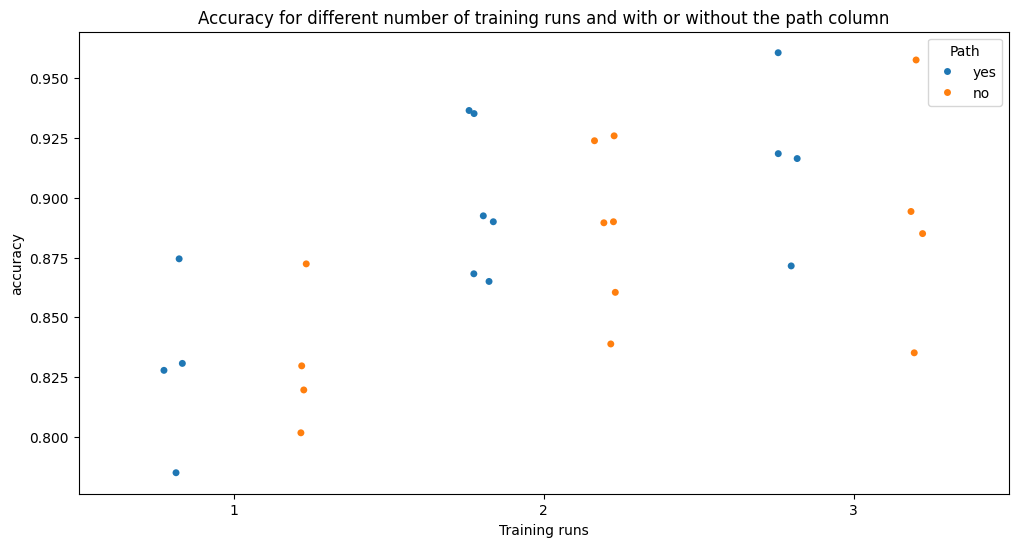

In [34]:
# plot the mean accuracy and the standard deviation for different number of runs and with or without the path column
# create a stripplot to show the distribution of the accuracies with seaborn

import seaborn as sns


df_without_path = df.copy(deep=True)

df_without_path.drop(['Path'],axis=1,inplace=True)

results_list = []

# we will use 2, 3, and 4 runs for training
for training_runs in [1,2, 3]:
    # Assuming cross_validation is a function that returns a list of accuracies
    accuracies = cross_validation(df_copy, 42, model, training_runs)
    for acc in accuracies:
        results_list.append({'Training runs': training_runs, 'accuracy': acc, 'Path': 'yes'})

    accuracies = cross_validation(df_without_path, 42, model, training_runs)
    for acc in accuracies:
        results_list.append({'Training runs': training_runs, 'accuracy': acc, 'Path': 'no'})

# Convert the list of dictionaries to a dataframe
results = pd.DataFrame(results_list)
# plot the results

plt.figure(figsize=(12, 6))

sns.stripplot(x='Training runs', y='accuracy', hue='Path', data=results, jitter=True, dodge=True)

plt.title("Accuracy for different number of training runs and with or without the path column")

plt.show()



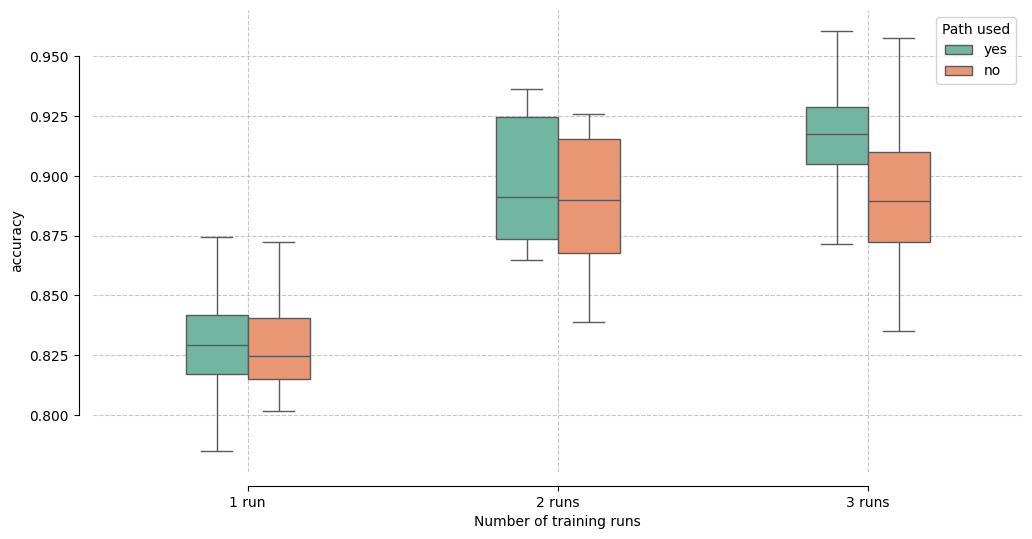

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the results dataframe is already defined

plt.figure(figsize=(12, 6))

# create a boxplot to show the distribution of the accuracies with seaborn
sns.boxplot(x='Training runs', y='accuracy', hue='Path', data=results, width=0.4, palette="Set2")

# Adjust the x-ticks labels
plt.xticks(ticks=[0, 1, 2], labels=['1 run', '2 runs', '3 runs'])

# Change the x-axis label
plt.xlabel("Number of training runs")

# Change the hue label to 'Path used'
plt.legend(title='Path used')


# Improve the overall styling
sns.despine(offset=10, trim=True)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

